In [2]:
import os
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
from torchvision import transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import time
import copy
from tqdm import tqdm

In [3]:
batch_size = 128


train_dir = "/home/khalil.alblooshi/labs/AI701/Project 4/denoising-pneumonia/noisy_data/train"
val_dir = "/home/khalil.alblooshi/labs/AI701/Project 4/denoising-pneumonia/noisy_data/val"
test_dir = "/home/khalil.alblooshi/labs/AI701/Project 4/denoising-pneumonia/noisy_data/test"

transform = transforms.Compose(
                [
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                ]
            )

train_data = ImageFolder(train_dir, transform=transform, loader=default_loader)
val_data = ImageFolder(val_dir, transform=transform, loader=default_loader)
test_data = ImageFolder(test_dir, transform=transform, loader=default_loader)

image_datasets = {'train': train_data, 'validation': val_data}


In [4]:
def START_seed():
    seed = 9
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
# load dataset
START_seed()
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, num_workers = 8)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True, num_workers = 8)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, num_workers = 8)

dataloaders = {
    'train': train_loader, 
    'validation':val_loader
}

images.shape: torch.Size([128, 3, 224, 224])


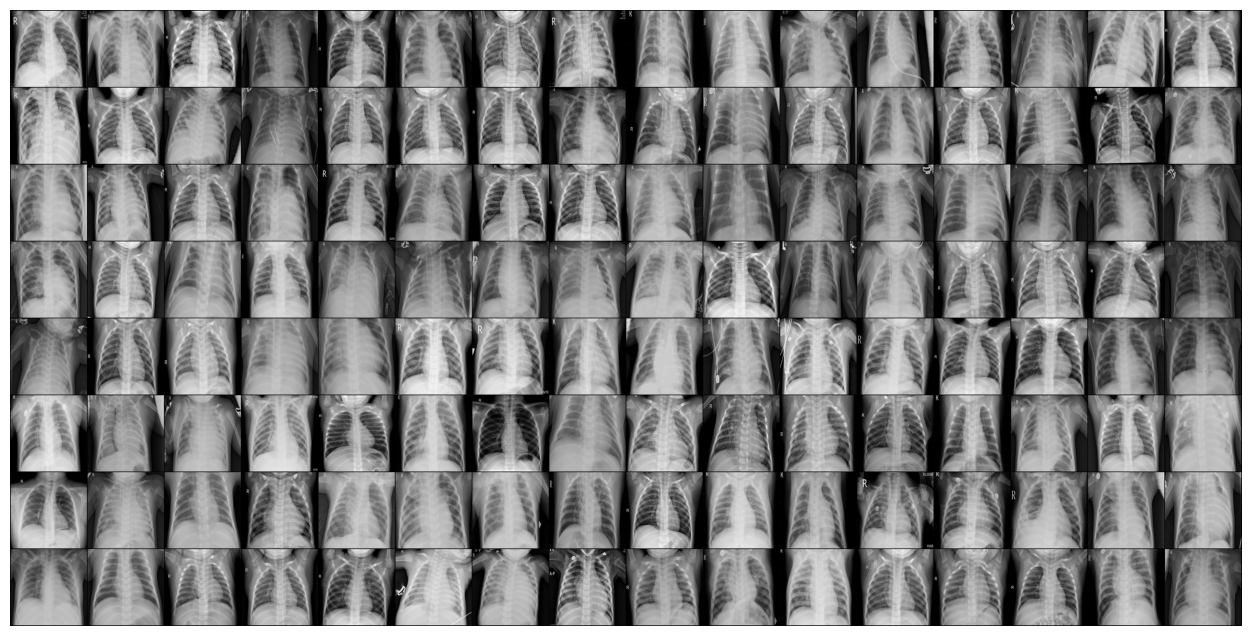

In [6]:

for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [7]:
from torchvision.models import resnet50#, ResNet50_Weights


# Load the weights into the model
resnet50_model = resnet50()

# print(resnet50_model.fc.in_features)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
resnet50_model = resnet50_model.to(device=device) 

# for param in model.parameters():
#     param.requires_grad = False   
    
resnet50_model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.BatchNorm1d(128),
               nn.Dropout(0.3),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

# Number of parameters
total_params = sum(p.numel() for p in resnet50_model.parameters())
print(total_params)

23770818


In [8]:
# Loss and optimizer
lr=1e-6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50_model.parameters(), lr= lr) 

In [9]:


def train_resnet(model, criterion, optimizer, num_epochs=3):
    best_model_wts = None
    best_acc = 0.0

    start_time = time.time()
    train_losses_per_epochs = []
    val_losses_per_epochs = []
    train_acc_per_epochs = []
    val_acc_per_epochs = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses_per_epochs.append(epoch_loss)
                train_acc_per_epochs.append(epoch_acc.item())
            else:
                val_losses_per_epochs.append(epoch_loss)
                val_acc_per_epochs.append(epoch_acc.item())

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            if phase == "validation" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, "resnet50_bm3d.pth")

    print("Time:", (time.time() - start_time))
    return model, train_losses_per_epochs, val_losses_per_epochs, train_acc_per_epochs, val_acc_per_epochs

In [10]:
resnet50_trained, train_losses_per_epochs, val_losses_per_epochs, train_acc_per_epochs, val_acc_per_epochs = train_resnet(resnet50_model, criterion, optimizer, num_epochs=20)

Epoch 1/20
----------
train loss: 0.5371, acc: 0.7544
validation loss: 1.1227, acc: 0.5000
Epoch 2/20
----------
train loss: 0.4660, acc: 0.8075
validation loss: 0.7125, acc: 0.5625
Epoch 3/20
----------
train loss: 0.4397, acc: 0.8273
validation loss: 0.5855, acc: 0.7500
Epoch 4/20
----------
train loss: 0.4174, acc: 0.8374
validation loss: 0.5995, acc: 0.7500
Epoch 5/20
----------
train loss: 0.4038, acc: 0.8470
validation loss: 0.5468, acc: 0.7500
Epoch 6/20
----------
train loss: 0.3955, acc: 0.8457
validation loss: 0.5773, acc: 0.7500
Epoch 7/20
----------
train loss: 0.3817, acc: 0.8577
validation loss: 0.5488, acc: 0.7500
Epoch 8/20
----------
train loss: 0.3698, acc: 0.8643
validation loss: 0.5986, acc: 0.7500
Epoch 9/20
----------
train loss: 0.3653, acc: 0.8616
validation loss: 0.5604, acc: 0.7500
Epoch 10/20
----------
train loss: 0.3577, acc: 0.8685
validation loss: 0.5382, acc: 0.6875
Epoch 11/20
----------
train loss: 0.3491, acc: 0.8685
validation loss: 0.5166, acc: 0.75

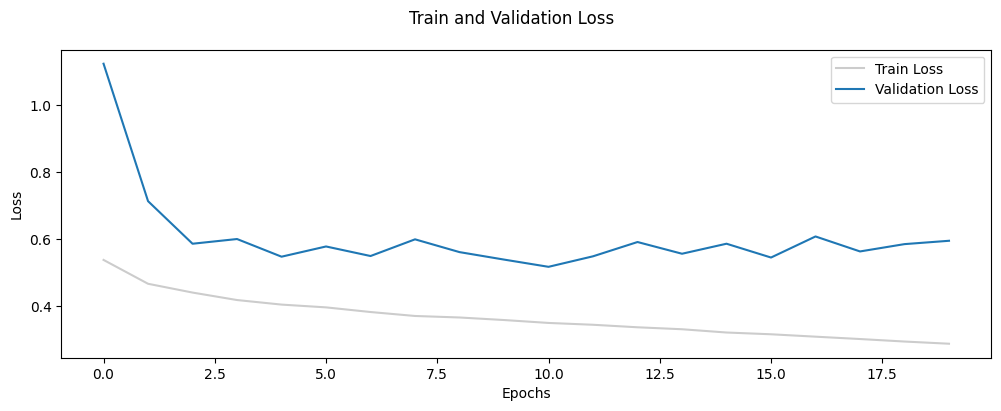

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Loss")
ax.plot(
    train_losses_per_epochs,
    alpha=0.2,
    label="Train Loss",
    color="black",
)
ax.plot(val_losses_per_epochs, label="Validation Loss")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
fig.savefig("Train_and_Validation_Loss_ResNet")

_ = ax.legend()

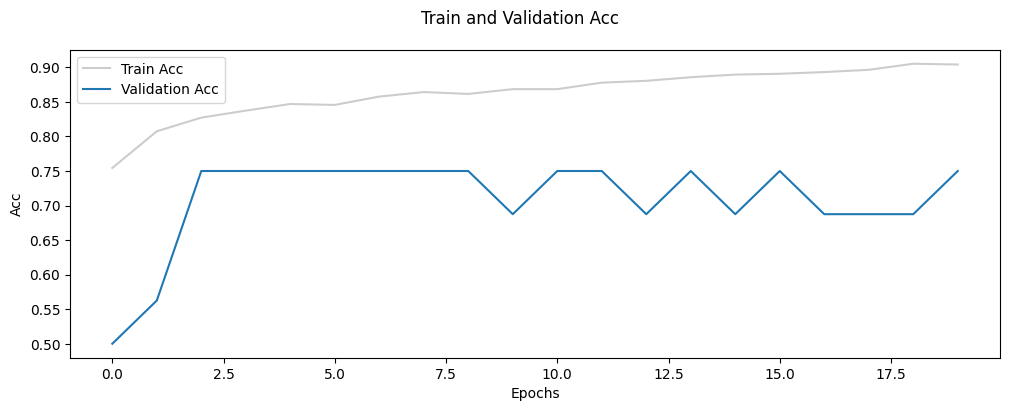

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Train and Validation Acc")
ax.plot(
    train_acc_per_epochs,
    alpha=0.2,
    label="Train Acc",
    color="black",
)
ax.plot(val_acc_per_epochs, label="Validation Acc")


# Set x-label and y-label
ax.set_xlabel("Epochs")
ax.set_ylabel("Acc")
fig.savefig("Train_and_Validation_Acc_ResNet")

_ = ax.legend()

In [26]:
def test_best_model(model, test_loader, criterion, best_model_path):
    # Load the best model
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0

    with tqdm(test_loader, unit="batch") as tepoch:
        for batch_idx, (data, target) in enumerate(tepoch):
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        accuracy = 100. * correct / total
        print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss/(batch_idx+1), accuracy))

In [28]:
best_resnet_path = '/home/khalil.alblooshi/labs/AI701/Project 4/denoising-pneumonia/ResNet50/resnet50.pth' 
test_best_model(model=resnet50_model, test_loader=test_loader, criterion=criterion, best_model_path=best_resnet_path)


100%|██████████| 5/5 [00:06<00:00,  1.29s/batch]

Test loss: 0.5374 Accuracy: 72.12%


In [50]:
import torch
from sklearn.metrics import confusion_matrix, classification_report

def test_best_model(model, test_loader, criterion, best_model_path, device):
    model.load_state_dict(torch.load(best_model_path))
    model.eval()

    test_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()

            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    accuracy = 100. * correct / total
    print('Test loss: {:.4f} Accuracy: {:.2f}%'.format(test_loss / len(test_loader), accuracy))

    # Confusion Matrix
    cm = confusion_matrix(all_targets, all_preds)
    class_labels = ['NORMAL', 'PNEUMONIA']

    # Display Confusion Matrix with Class Labels as Text
    cm_text = '\t' + '\t'.join(class_labels) + '\n'
    for i, row in enumerate(cm):
        row_text = '\t'.join(['{:4}'.format(item) for item in row])
        cm_text += f"{class_labels[i]}\t{row_text}\n"
    print(f"Confusion Matrix:\n{cm_text}")

    # Classification Report
    report = classification_report(all_targets, all_preds, target_names=class_labels)
    print(report)


In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_best_model(model=resnet50_model, test_loader=test_loader, criterion=criterion, best_model_path=best_resnet_path, device=device)

Test loss: 0.5374 Accuracy: 72.12%
Confusion Matrix:
	NORMAL	PNEUMONIA
NORMAL	 115	 119
PNEUMONIA	  55	 335

              precision    recall  f1-score   support

      NORMAL       0.68      0.49      0.57       234
   PNEUMONIA       0.74      0.86      0.79       390

    accuracy                           0.72       624
   macro avg       0.71      0.68      0.68       624
weighted avg       0.71      0.72      0.71       624



SSIM is a measure of similarity between two images (1: perfect similarity, 0 no similarity, -1 perfect anti correlation)